# Grokking Live (Tiny Transformer)

Train a tiny transformer on modular addition and watch **live plots inside Jupyter**.

In [1]:
# If needed, run once:
# %pip install torch matplotlib

import random
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython.display import clear_output

device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: mps


In [6]:
@dataclass
class CFG:
    prime: int = 97
    train_frac: float = 0.3
    d_model: int = 128
    nhead: int = 4
    nlayers: int = 2
    dropout: float = 0.0
    batch_size: int = 256
    steps: int = 5000000
    eval_every: int = 100
    lr: float = 1e-3
    weight_decay: float = 1e-2
    seed: int = 42

cfg = CFG()
random.seed(cfg.seed)
torch.manual_seed(cfg.seed)

In [7]:
def build_dataset(p):
    xs, ys = [], []
    for a in range(p):
        for b in range(p):
            xs.append((a, b))
            ys.append((a + b) % p)
    return torch.tensor(xs, dtype=torch.long), torch.tensor(ys, dtype=torch.long)

class TinyTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, nlayers, dropout, out_classes):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Parameter(torch.randn(2, d_model) * 0.02)

        layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4*d_model,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=nlayers)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, out_classes)

    def forward(self, x):
        h = self.token_emb(x) + self.pos_emb.unsqueeze(0)
        h = self.encoder(h)
        h = self.norm(h[:, -1, :])
        return self.head(h)

@torch.no_grad()
def evaluate(model, x, y, bs=2048):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for i in range(0, len(x), bs):
        xb = x[i:i+bs]
        yb = y[i:i+bs]
        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        pred = logits.argmax(dim=-1)
        correct += (pred == yb).sum().item()
        total += yb.numel()
        loss_sum += loss.item() * yb.size(0)
    return loss_sum/total, correct/total

def batch_sample(x, y, bs):
    idx = torch.randint(0, len(x), (bs,), device=x.device)
    return x[idx], y[idx]

In [8]:
# Build data/model
x, y = build_dataset(cfg.prime)
perm = torch.randperm(len(x))
train_n = int(cfg.train_frac * len(x))
tr_idx, te_idx = perm[:train_n], perm[train_n:]

x_train, y_train = x[tr_idx].to(device), y[tr_idx].to(device)
x_test, y_test = x[te_idx].to(device), y[te_idx].to(device)

model = TinyTransformer(cfg.prime, cfg.d_model, cfg.nhead, cfg.nlayers, cfg.dropout, cfg.prime).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

print('Train size:', len(x_train), 'Test size:', len(x_test))

Train size: 2822 Test size: 6587


/var/folders/64/19qfvx8n6z71crkfzp88szzc0000gn/T/ipykernel_32806/3702462383.py:24: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  self.encoder = nn.TransformerEncoder(layer, num_layers=nlayers)


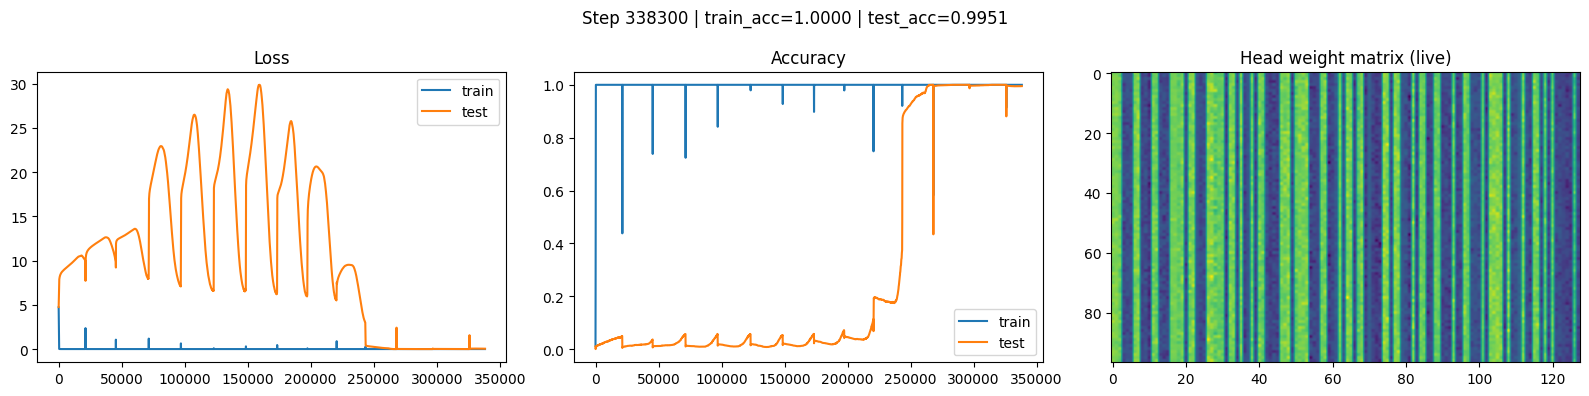

KeyboardInterrupt: 

In [9]:
# Live training + live plots
steps_hist = []
tr_loss_hist, te_loss_hist = [], []
tr_acc_hist, te_acc_hist = [], []

for step in range(1, cfg.steps + 1):
    model.train()
    xb, yb = batch_sample(x_train, y_train, cfg.batch_size)
    logits = model(xb)
    loss = F.cross_entropy(logits, yb)

    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()

    if step % cfg.eval_every == 0 or step == 1:
        tr_loss, tr_acc = evaluate(model, x_train, y_train)
        te_loss, te_acc = evaluate(model, x_test, y_test)

        steps_hist.append(step)
        tr_loss_hist.append(tr_loss)
        te_loss_hist.append(te_loss)
        tr_acc_hist.append(tr_acc)
        te_acc_hist.append(te_acc)

        clear_output(wait=True)
        fig, ax = plt.subplots(1, 3, figsize=(16, 4))

        ax[0].plot(steps_hist, tr_loss_hist, label='train')
        ax[0].plot(steps_hist, te_loss_hist, label='test')
        ax[0].set_title('Loss')
        ax[0].legend()

        ax[1].plot(steps_hist, tr_acc_hist, label='train')
        ax[1].plot(steps_hist, te_acc_hist, label='test')
        ax[1].set_title('Accuracy')
        ax[1].legend()

        W = model.head.weight.detach().float().cpu()
        ax[2].imshow(W, aspect='auto')
        ax[2].set_title('Head weight matrix (live)')

        plt.suptitle(f'Step {step} | train_acc={tr_acc:.4f} | test_acc={te_acc:.4f}')
        plt.tight_layout()
        plt.show()

print('Done')

### If jump is not obvious
- Increase `cfg.steps` to 50k+
- Keep `train_frac` in 0.2–0.4
- Keep non-zero `weight_decay`
- Try smaller model: `d_model=64`